**Workflow: P/PET Average in April vs. in April 2020**

- connect to aWhere's API
- call ppet for April 2020 for test area (Yreka)
 - may have to make multiple requests
 - join data into 1 main dataframe
- get ppet for April 2019 for same site
- find difference in values and save to df
- call ppet for each site in grid geodataframe

In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

import geopandas as gpd
import earthpy as et

import requests as rq

from header import AWhereAPI
from secret_codes import *

In [2]:
# Import codes from secret_codes.py
api_key = API_KEY
api_secret = API_SECRET

In [3]:
# Create aWhere object
aw = AWhereAPI(api_key, api_secret)

# To get auth token, encode secret and key
sc = aw.encode_secret_and_key(API_KEY, API_SECRET)

# Then call auth token
token = aw.get_oauth_token(sc)

# Set up headers: auth and specific header for agronomics data
auth_headers = {"Authorization": "Bearer %s" % token,
                "Content-Type": 'application/json'}

agro_header = {"Authorization":  "Bearer %s" % token}

# General aWhere API endpoint "prefix"
endpt = "https://api.awhere.com"

In [6]:
# Function to fetch agronomic norms json
# given lat, long, start, end day ("day" can include year)

def agro_json(start_day, end_day, latitude, longitude, search_type, properties=None):
    """
    Reads in temporal and spatial info and returns JSON-like object. Additional param
    allows user to enter specific search parameters.

    Parameters
    ----------
    start_day, end_day: string
        Formatted as MM-DD for historical averages
        or YYYY-MM-DD for specific date range

    longitude, latitude: string, int, or float
        Decimal degrees location of centroid of
        9 sq km grid to get agronomic info for

    search_type: string
        Accepts "norms" for historical norms
        or "values" for specific date range

    properties: string (optional)
        User-defined string with optional additional 
        search parameters

    Returns
    -------
    ag_json: JSON-like object
        Contains response from aWhere's agronomics
        API.
    """

    if properties:

        hist_ag_url = f"/v2/agronomics/locations/{latitude},{longitude}/agronomic{search_type}/{start_day},{end_day}{properties}"

    else:

        hist_ag_url = f"/v2/agronomics/locations/{latitude},{longitude}/agronomic{search_type}/{start_day},{end_day}"

    # Get JSON from API
    ag_json = rq.get((endpt + hist_ag_url), headers=agro_header).json()

    return ag_json

In [7]:
# Return average P/PET for April based on historic norms

# Set lat and long of Yreka, CA
latitude = 41.726667
longitude = -122.6375

# List to hold all returned JSONs (3 in total)
json_list = []

# Set start and end day
start_day = "04-01"
end_day = "04-30"

# specify pages, 10 results per page:
pages = 3

for page in range(0, pages):
    
    # Find offset for later JSONs
    offset = page * 10
    
    if offset > 0:

        # Get json
        period_json = agro_json(start_day, end_day, latitude, longitude, "norms",
                                f"?limit=10&offset={offset}")
    else:
        period_json = agro_json(start_day, end_day, latitude, longitude, "norms")

    # Add json to list of JSONs
    json_list.append(period_json)

In [8]:
# A list of lists, with each sublist holding a "row"
# to add to the eventual df

master_list = []

for period_json in json_list:

    # For each day in all days in json
    for day in range(0, len(period_json['dailyNorms'])):

        # List to hold values from specific day
        day_list = []

        # Add date
        day_list.append(period_json['dailyNorms'][day].get('day'))

        # Add average ppet
        day_list.append(period_json['dailyNorms']
                        [day].get('ppet').get('average'))

        # Add ppet stddev
        day_list.append(period_json['dailyNorms']
                        [day].get('ppet').get("stdDev"))

        # Add accumulated ppet average
        day_list.append(period_json['dailyNorms'][day].get(
            'accumulatedPpet').get('average'))

        # Add accumulated ppet stddev
        day_list.append(period_json['dailyNorms'][day].get(
            'accumulatedPpet').get('stdDev'))

        # Add list to "list of lists"
        master_list.append(day_list)

# Convert master list to dataframe
ppet_april_norms = pd.DataFrame(master_list, columns=['day', 'ppet_avg', 'ppet_std',
                                                      'accumulated_ppet_avg', 'accumulated_ppet_std'])

In [9]:
# Get April 2020 agronomic values

# Location for Yreka, CA
latitude = 41.726667
longitude = -122.6375

start_day = "2020-04-01"
end_day = "2020-04-30"

# specify pages, 10 results per page:
pages = 3

# Holds all  returned JSONs 
json_list = []

for page in range(0, pages+1):

    offset = (page * 10)

    # Get json
    period_json = agro_json(start_day, end_day, latitude, longitude, "values",
                                f"?limit=10&offset={offset}")

    # Add json to list of JSONs
    json_list.append(period_json)

In [10]:
# Holds all rows for all JSONs
master_list = []

for period_json in json_list:

    # For each day in all days in json
    for day in range(0, len(period_json['dailyValues'])):

        # List to hold values from specific day
        day_list = []

        day_list.append(period_json['dailyValues'][day].get('date'))

        # Get daily ppet
        day_list.append(period_json['dailyValues'][day].get('ppet'))
        
        # Get accumulated ppet
        day_list.append(period_json['dailyValues'][day].get('accumulatedPpet'))

        master_list.append(day_list)
        
ppet_april_2020 = pd.DataFrame(master_list, columns=['day', 'daily_ppet', 'accumulated_ppet'])

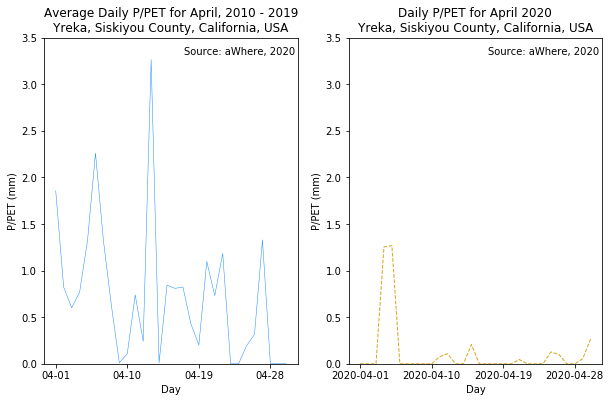

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,6))

# Set labels and title
ax1.set(title="Average Daily P/PET for April, 2010 - 2019\n" +
       "Yreka, Siskiyou County, California, USA",
       xlabel="Day",
       ylabel="P/PET (mm)")

# Create plot of average P/PET
ax1.plot(ppet_april_norms.day, ppet_april_norms.ppet_avg, 
         label="Daily Average P/PET, April (mm)", linewidth=0.5, color='dodgerblue')

# Set ticker at regular intervals
tic = plticker.MultipleLocator(base=9.0)
ax1.xaxis.set_major_locator(tic)

# Plots have same scale
ax1.set_ylim((0,3.5))

# Add source info
ax1.text(0.55, 0.95, transform=ax1.transAxes, s="Source: aWhere, 2020")

"""Plot 2: This April"""
# Set labels and title
ax2.set(title="Daily P/PET for April 2020\n" +
       "Yreka, Siskiyou County, California, USA",
       xlabel="Day",
       ylabel="P/PET (mm)")

# Create plot of average P/PET
ax2.plot(ppet_april_2020.day, ppet_april_2020.daily_ppet, label="P/PET", 
         linewidth=1, color='goldenrod', linestyle='--')

# Set ticker at regular intervals
tic = plticker.MultipleLocator(base=9.0)
ax2.xaxis.set_major_locator(tic)

# Plots have same scale
ax2.set_ylim((0,3.5))

# Add source info
ax2.text(0.55, 0.95, transform=ax2.transAxes, s="Source: aWhere, 2020")

# Create export path
fig_3_path = os.path.join(et.io.HOME, "desktop", "drought", "data", "images", "fig_3.png")

# Save figure
plt.savefig(fig_3_path, bbox_inches="tight")

plt.show()

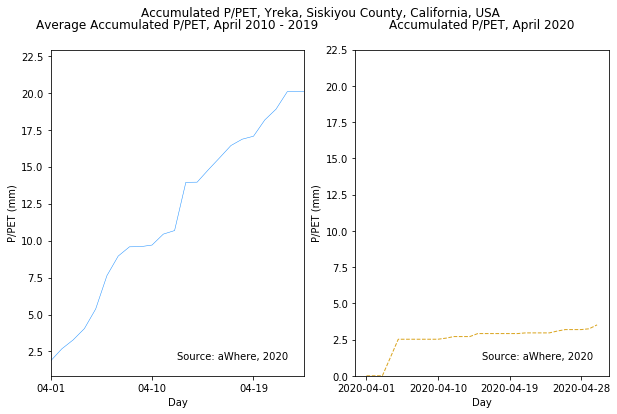

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

fig.suptitle("Accumulated P/PET, Yreka, Siskiyou County, California, USA")


"""Plot 1: Historic Values (April)"""

# Set labels and title
ax1.set(title="Average Accumulated P/PET, April 2010 - 2019\n",
        xlabel="Day",
        ylabel="P/PET (mm)")

# Create plot of average accumulated ppet
ax1.plot(ppet_april_norms.day, ppet_april_norms.accumulated_ppet_avg,
         label="Average accumulated P/PET (mm)", linewidth=0.5, color='dodgerblue')

# Set ticker at regular intervals
tic = plticker.MultipleLocator(base=9.0)
ax1.xaxis.set_major_locator(tic)

# Set plots to be same size
ax1.set_xlim((0, 22.5))

# Add source info
ax1.text(0.5, 0.05, transform=ax1.transAxes, s="Source: aWhere, 2020")

"""Plot 2: This April"""
# Set labels and title
ax2.set(title="Accumulated P/PET, April 2020\n",
        xlabel="Day",
        ylabel="P/PET (mm)")

# Create plot of accumulated P/PET
ax2.plot(ppet_april_2020.day, ppet_april_2020.accumulated_ppet,
         label="Accumulated P/PET (mm)", linewidth=1, color='goldenrod', linestyle='--')

# Set ticker at regular intervals
tic = plticker.MultipleLocator(base=9.0)
ax2.xaxis.set_major_locator(tic)

# Scale same as plot 1
ax2.set_ylim((0, 22.5))

# Add source info
ax2.text(0.5, 0.05, transform=ax2.transAxes, s="Source: aWhere, 2020")

# Create export path
fig_4_path = os.path.join(et.io.HOME, "desktop", "drought", "data", "images", "fig_4.png")

# Save figure
plt.savefig(fig_4_path, bbox_inches="tight")

plt.show()